In [ ]:
# Imports
import polars as pl
import matplotlib.pyplot as plt 
import re
from tennis_match_predictor.config import INTERIM_DATA_DIR

### Cleaning Combined Dataset

In [160]:
# Load dataframe
df = pl.read_csv("../data/interim/joined_dataset_raw.csv")

In [161]:
# Display all columns from joined dataframe
print("Number of columns: ", len(df.columns))
print("Columns: ", df.columns)

Number of columns:  86
Columns:  ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points', 'Year', 'w_name_key', 'l_name_key', 'round_key', 'ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment', 'B365W', 'B365L', 'EXW', 'EXL', 'LBW', 'LBL', 'PSW', 'PSL', 'SJW', 'SJL', 'MaxW', 'MaxL', 'AvgW', 'AvgL']


As seen above, there are a lot of columns now that the datasets are merged. However, a lot of the columns contain duplicate information as a product of joining, like the tournament name. There are also unique identifiers that both datasets used which are no longer needed. Finally, redudant information will be dropped, such as specific betting odds from each site (only the max and average will be kept). 

In [162]:
# Remove unnecessary columns
cols_to_drop = [
    # Unique identifiers
    "tourney_id", "match_num", "winner_id", "loser_id", "ATP", 

    # Redundant columns
    "tourney_level", "tourney_date", "winner_seed", "loser_seed", "w_name_key", "l_name_key", "round_key", 
    "Location", "Tournament", "W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5",
    
    # Betting odds
    "B365W", "B365L", "EXW", "EXL", "LBW", "LBL", "PSW", "PSL", "SJW", "SJL"
] 

df_clean = df.drop(cols_to_drop)

In [163]:
# Reorganize columns in better format
reordered_cols = [
    # Match metadata
    'Year', 'Date', 'tourney_name', 'Series', 'Court', 'surface', 'draw_size', 'best_of', 'minutes', 'round', 'score', 'Comment',
    
    # Winner player profile
    'winner_name', 'winner_rank', 'winner_rank_points', 'winner_entry', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
    
    # Loser player profile
    'loser_name', 'loser_rank', 'loser_rank_points', 'loser_entry', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
    
    # Winner match statistics
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    
    # Loser match statistics
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
    
    # Sets won
    'Wsets', 'Lsets',
    
    # Betting odds
    'MaxW', 'MaxL', 'AvgW', 'AvgL'
]

df_clean = df_clean.select(reordered_cols)

We also want to make sure to remove any matches that were not played due to walkover (one player forfeits before a match starts), causing missing data. Also, some matches are never finished due to a player retiring/getting defaulted mid match, so those will be removed as well. 

In [164]:
df_clean = df_clean.filter(
    pl.col("Comment") == "Completed"
)

print(f"Removed {len(df) - len(df_clean)} rows")

Removed 5594 rows


In [165]:
# Check missing values
df_clean.null_count()

Year,Date,tourney_name,Series,Court,surface,draw_size,best_of,minutes,round,score,Comment,winner_name,winner_rank,winner_rank_points,winner_entry,winner_hand,winner_ht,winner_ioc,winner_age,loser_name,loser_rank,loser_rank_points,loser_entry,loser_hand,loser_ht,loser_ioc,loser_age,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,Wsets,Lsets,MaxW,MaxL,AvgW,AvgL
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,1197,0,0,0,0,0,0,18576,0,2,0,0,0,0,0,16505,0,23,0,0,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,0,0,15,15,15,15


The following columns are correct as null:
- winner_entry
- loser_entry

The main way to enter an ATP tournament is through a high enough ranking. However, there are some spots reserved for special conditions, such as the qualifying tournament, getting a wild card, etc. If a player enters with their ATP ranking, this column shows as null. Eventually, there will be another column added to replace this i.e encoding. For the time being, we can just fill these null values with a new string.

In [166]:
# DE = direct entry (using ATP ranking)
df_clean = df_clean.with_columns(
    pl.col("winner_entry").fill_null("DE"),
    pl.col("loser_entry").fill_null("DE")
)

The "minutes" column also has a lot of missing values. Since we do not want to remove this many matches, we can estimate the match duration using the score.

In [167]:
# Clean "minutes column" from outliers 
# Most matches (including Grand Slam 5 setters) are under 6 hours, so check if any matches are above this
# Manually fix any match duration that may be incorrect 
print(df_clean.filter(pl.col("minutes") > 360))

# Only the first two match durations are incorrect, so we can manually override 
df_clean = df_clean.with_columns(
    pl.when(pl.col("minutes") == 1146).then(None)  # match stats for Muller d. Chardy are not available
     .when(pl.col("minutes") == 987).then(98)
     .otherwise(pl.col("minutes"))
     .alias("minutes")
)

# Only 2 matches longer than 6 hours
assert len(df_clean.filter(pl.col("minutes") > 360)) == 2

shape: (4, 52)
┌──────┬────────────┬───────────────┬────────────┬───┬──────┬──────┬──────┬──────┐
│ Year ┆ Date       ┆ tourney_name  ┆ Series     ┆ … ┆ MaxW ┆ MaxL ┆ AvgW ┆ AvgL │
│ ---  ┆ ---        ┆ ---           ┆ ---        ┆   ┆ ---  ┆ ---  ┆ ---  ┆ ---  │
│ i64  ┆ str        ┆ str           ┆ str        ┆   ┆ f64  ┆ f64  ┆ f64  ┆ f64  │
╞══════╪════════════╪═══════════════╪════════════╪═══╪══════╪══════╪══════╪══════╡
│ 2016 ┆ 2016-01-15 ┆ Sydney        ┆ ATP250     ┆ … ┆ 1.81 ┆ 2.2  ┆ 1.75 ┆ 2.05 │
│ 2017 ┆ 2017-05-06 ┆ Munich        ┆ ATP250     ┆ … ┆ 1.93 ┆ 2.07 ┆ 1.83 ┆ 1.96 │
│ 2018 ┆ 2018-07-13 ┆ Wimbledon     ┆ Grand Slam ┆ … ┆ 2.15 ┆ 1.93 ┆ 2.01 ┆ 1.84 │
│ 2020 ┆ 2020-09-28 ┆ Roland Garros ┆ Grand Slam ┆ … ┆ 5.3  ┆ 1.24 ┆ 4.77 ┆ 1.19 │
└──────┴────────────┴───────────────┴────────────┴───┴──────┴──────┴──────┴──────┘


In [168]:
def calc_match_components(score):
    if not score:
        return None, None, None
    
    # Remove tiebreak subscore ex. 7-6(4) -> 7-6
    clean_score = re.sub(r'\(\d+\)', '', score)
    sets = clean_score.split()
    
    total_games = 0
    total_sets = len(sets)
    changeovers = 0
    
    for set_score in sets:
        if '-' in set_score:
            try:
                games = set_score.split('-')
                set_games = int(games[0]) + int(games[1])
                total_games += set_games
                
                # Changeovers happen after odd-numbered games (1,3,5,7,...)
                # In a set with N total games, there are floor(N/2) changeovers
                changeovers += set_games // 2
                
            except:
                continue
    
    # Set breaks = number of completed sets (total sets - 1)
    set_breaks = max(0, total_sets - 1)
    
    return total_games, changeovers, set_breaks

def calc_total_duration(score, game_mins=3.5, changeover_mins=1.5, set_break_mins=2.0):
    """
    Estimate total match duration including:
    - Game time: games * game_mins 
    - Changeovers: changeovers * changeover_mins (90 seconds = 1.5 mins)
    - Set breaks: set_breaks * set_break_mins
    """
    components = calc_match_components(score)
    if components[0] is None:
        return None
    
    games, changeovers, set_breaks = components
    
    total_mins = (games * game_mins + 
                  changeovers * changeover_mins + 
                  set_breaks * set_break_mins)
    
    return total_mins

df_clean = df_clean.with_columns([
    pl.col("score").map_elements(calc_total_duration, return_dtype=pl.Float64).alias("estimated_minutes")
]).with_columns([
    pl.when(pl.col("minutes").is_null())
    .then(pl.col("estimated_minutes"))
    .otherwise(pl.col("minutes"))
    .alias("minutes")
]).with_columns([
    (pl.col("minutes") - pl.col("estimated_minutes")).alias("min_diff")  # to calculate error
])

Mean Absolute Error:  11.618549416484319
Root Mean Square Error:  15.722325625272626


(-100.0, 100.0)

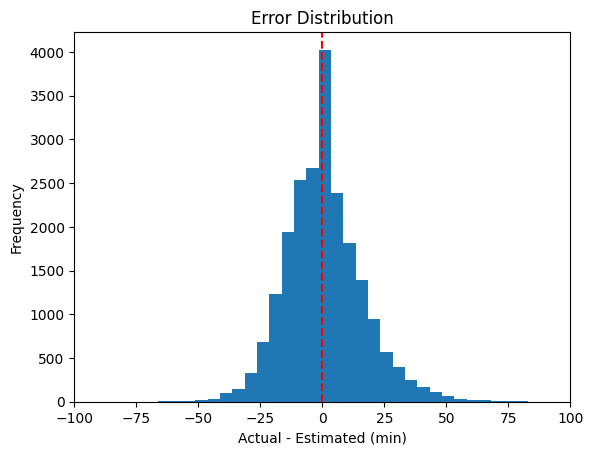

In [169]:
# Calculate error for minute estimation 
mae = df_clean.select(pl.col("min_diff").abs().mean()).item()
rmse = df_clean.select((pl.col("min_diff") ** 2).mean().sqrt()).item()

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse )

# Plot histogram of differences
plt.hist(df_clean["min_diff"], bins=50)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Actual - Estimated (min)")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.xlim(-100, 100)

Given that the MAE and RMSE are relatively low and the histogram shows a normal distribution, this estimation of null minutes can be used.

In [170]:
# Drop columns used for calculations
df_clean = df_clean.drop(pl.col(["estimated_minutes", "min_diff"]))

In [171]:
# Determine percentage of null values left 
print(f"{(df_clean.null_count()["winner_ht"][0] / len(df_clean) * 100):.2f}% of matches have null winner heights")
print(f"{(df_clean.null_count()["loser_ht"][0] / len(df_clean) * 100):.2f}% of matches have null loser heights")
print(f"{(df_clean.null_count()["w_SvGms"][0] / len(df_clean) * 100):.2f}% of matches have null winner/loser match statistics")
print(f"{(df_clean.null_count()["AvgW"][0] / len(df_clean) * 100):.2f}% of matches have null betting odds")

0.01% of matches have null winner heights
0.10% of matches have null loser heights
0.04% of matches have null winner/loser match statistics
0.07% of matches have null betting odds


In [172]:
# Drop nulls since they make up <0.15% of our dataset
df_clean = df_clean.drop_nulls(subset=["winner_ht", "loser_ht", "w_SvGms", "AvgW"])

In [ ]:
# Make sure all missing values are removed
assert sum(df_clean.null_count()).item() == 0

In [174]:
# Add dataset to data/interim for future use
output_path = INTERIM_DATA_DIR / "joined_dataset_clean.csv"
df_clean.write_csv(output_path)